<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Скачивание-и-импорт-библиотек" data-toc-modified-id="Скачивание-и-импорт-библиотек-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Скачивание и импорт библиотек</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ данных</a></span><ul class="toc-item"><li><span><a href="#Выделение-обучающей-и-тестовой-выборок" data-toc-modified-id="Выделение-обучающей-и-тестовой-выборок-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Выделение обучающей и тестовой выборок</a></span></li><li><span><a href="#Удаление-слов-нейтральной-тональности" data-toc-modified-id="Удаление-слов-нейтральной-тональности-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Удаление слов нейтральной тональности</a></span></li></ul></li><li><span><a href="#Векторизация-текста-и-обучение-моделей" data-toc-modified-id="Векторизация-текста-и-обучение-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Векторизация текста и обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Поиск-наилучших-гиперпараметров-при-помощи-GridSearchCV" data-toc-modified-id="Поиск-наилучших-гиперпараметров-при-помощи-GridSearchCV-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Поиск наилучших гиперпараметров при помощи GridSearchCV</a></span></li><li><span><a href="#Поиск-наилучших-гиперпараметров-при-помощи-Optuna" data-toc-modified-id="Поиск-наилучших-гиперпараметров-при-помощи-Optuna-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Поиск наилучших гиперпараметров при помощи Optuna</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

# Описание проекта

***Проект для «Викишоп»***

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.
Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.
Постройте модель со значением метрики качества F1 не меньше 0.75.

# Скачивание и импорт библиотек

In [1]:
!{sys.executable} -m spacy download en

"{sys.executable}" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [2]:
import re
import sys
import time
import warnings

import geograpy

import matplotlib.pyplot as plt

import numpy as np

import optuna
from optuna.samplers import RandomSampler

import pandas as pd

import spacy

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.exceptions import FitFailedWarning, ConvergenceWarning
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm  import SVC
from sklearn.utils._testing import ignore_warnings

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to C:\Users\Zakhar
[nltk_data]     Kousnetsov\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Zakhar
[nltk_data]     Kousnetsov\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Zakhar
[nltk_data]     Kousnetsov\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
pd.set_option('display.max_colwidth', None)

# Анализ данных

In [5]:
try:
    data = pd.read_csv('toxic_comments.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

Посмотрим на содержание датасета

In [6]:
data.sample(3)

,text,toxic
8552,"Javier Patiño \n\nNo warnings yet, but the table you were fighting over is unrefernced so I've removed it completely. Snowman",0
111801,"""\n\nYou deleted by addition to the """"miscarriage of justice"""" page. This is a legitimate site and link, and is not spam. It's a valid organization dedicated to fixing wrongful convictions of Kevin Thornton and others, and is used frequently by the Innocence Project and others. Please re-insert.\n\n""",0
63457,"""\nTry every single time I type something.... unless you have selective reading as well. The palegoldenrod is used in the header as well, not just in conflict with the yellow. – (talk) """,0


В датасете содержится некоторое количество твитов с присвоенной каждому оценкой тональности: токсичный или нет. Посмотрим на общую информацию

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Всего в датасете 159571 твит, каждому присвоена оценка, пропусков нет.

Исследуем дисбаланс классов

In [8]:
data['toxic'].value_counts(normalize=True)

0    0.898321
1    0.101679
Name: toxic, dtype: float64

В целевом признаке прослеживается сильный дисбаланс классов. При обучении нужно будет принять меры по его компенсации

Проверим наличие в тексте неинформативных элементов: хэштегов, ip-адресов, цифр. Выведем их количество

In [9]:
display(data[data['text'].str.contains(r'#\S+')].sample())
print('Всего в корпусе {} текстов с хэштегами'.format(data['text'].str.contains('#\S+').sum()))

display(data[data['text'].str.contains('http[s]?\://\S+')].sample())
print('Всего в корпусе {} текстов с названиями сайтов'.format(data['text'].str.contains('http[s]?\://\S+').sum()))

,text,toxic
153241,"""\n\n Korean article template \n\nHi, thanks for your question. Sorry I'm so late getting back to you. Life on and off Wikipedia has been full of all sorts of unexpected hecticity... Anyway, the Korean article template. \n\nThe idea behind the template is pretty simple. The basic idea is that every article should have the following, unless there is some reason to the contrary:\n a relevant """"See also"""" section, \n at least one relevant Korea-related category, and\n a name table. \n Template:Korean on the Talk page.\n\nIn more detail...\nThe """"See also"""" section should include a link to the List of Korea-related topics (LKRT), and anything else that's obviously relevant but not linked in the article text. If you prefer, you can just put in the LKRT link and let someone else add the others. If you want to add more, here's the rule I've been following: look in each category of which the article is a member. If that category has a main article (like Korea in Category:Korea), then that main article should be linked either from the text, or from the See also section. The same for parent categories, within reason. Here's an example: Munmu of Silla is a member of the categories Silla and Korean rulers. Thus, the articles Silla and Rulers of Korea are linked in the article text. Those two categories are part of Category:Korean history and Category:Korean people. Thus, History of Korea is linked in the See also section, and so is List of Koreans (well, it is now). Both of those are members of Category:Korea, hence the link to the LKRT. \nYou can find a complete (?) list of Korea-related categories at List of Korea-related topics#Categories. Or just start at Category:Korea and work your way down.\nTemplate:Koreanname noimage is fine for the vast majority of articles. Cut and paste Template talk:Koreanname noimage#Syntax and fill in the blanks. All Korean name tables require you to specify at least these four variables: hangul, hanja, rr, and mr. """"Rr"""" stands for Revised Romanization of Korean, and """"mr"""" stands for McCune-Reischauer Romanization. If you don't know what should go in these fields, just leave them blank however, at a minimum the hangul should be provided (that allows other editors to verify the article and identify the other name-related information). You can request help on the Korea-related notice board. \nThis one's easy. Just paste {{Korean}} onto the top of the talk page. Done!\n\nMost of our existing articles should already conform to this, since we just finished a housekeeping sweep in June. But there are more new ones coming in every day...\n\nI've also taken to adding a """"Wish list"""" to the talk pages of new/inactive articles, identifying 2 or 3 things that the article is lacking. Hopefully this will help other contributors see where they can help. (Of course, if I can contribute the information myself, I do so).\n\nI hope this isn't all too overwhelming. Your excellent work so far is much appreciated. \n\nCheers,\n\n """,0


Всего в корпусе 3276 текстов с хэштегами


,text,toxic
105483,"""Christiania ==\n\nflag> http://www.fotw.net/images/d/dk-chris.gif\nby Edward Mooney, Jr. 2000-12-08\n\ninfo> * you limit your use to a maximum of 5% of the images or content of the website\n * you quote the author\n * you quote the website (as """"FOTW Flags Of The World website at http://flagspot.net/flags/"""")\n * you do not alter in any way the images or the content of the text\n * you use the material for non-commercial and non-political purposes only\n * if you distribute our material by a non-Internet way (e.g., floppy disks or CD-ROM) you must add this copyright text on every copy of the medium\n * if you distribute our materials by a non-Internet way (e.g., floppy disks or CD-ROM) you cannot sell these media\n * if you want to mirror the Web, read these additional rules\n * If you want to reuse FOTW GeoIndex maps and boundaries' data, read these rules \n\n """,0


Всего в корпусе 4774 текстов с названиями сайтов


Очистим все твиты от неинформативных символов и приведем все слова к леммам при помощи библиотеки `spaCy`

In [10]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
def cleaner_lemmatizer(text):
    cleaned_text = ' '.join(re.sub(r'(#\S+)|(http[s]?\://\S+)|[^a-zA-Z]', ' ', text).split())
    return ' '.join([token.lemma_ for token in nlp(cleaned_text)]).lower().strip()

Убедимся, что это работает

In [11]:
data.loc[[111, 222, 333], 'text'].apply(func=lambda x: cleaner_lemmatizer(x)).to_frame()

,text
111,comment i could not verify the claim talk
222,you be wrong although i be block on some occasion i be never block for sockpuppetry or vandalism it be because of dispute on multiple topic with various sock of user hkelkar user vandalpetrol both of which be permabanne i have never use any other account if you be permit to edit then you should get other account delete which say you be indeffe no blast
333,unsure at this stage its not very clear what wording be actually be discuss


Чтобы сэкономить время, загрузим датасет с уже очищенными и лемматизированными твитами 

In [12]:
%%time
try:
    data = pd.read_csv('data_cleaned_and lemmatized_v2').drop('Unnamed: 0', axis=1)
except:
    data['lemmatized'] = data.loc[:, 'text'].apply(func=lambda x: cleaner_lemmatizer(x))

Wall time: 1.19 s


In [13]:
data.sample(3)

,text,toxic,lemmatized
47633,"""\nNon-free images are strictly limited to certain extremely limited situations where obtaining a replacement is impossible - see WP:NFC. Non-replaceable does not simply mean """"not easily available on the Internet"""" - there are plenty of opportunities to take a free-content picture of a transman for the article. ✽ """,0,non free image be strictly limit to certain extremely limited situation where obtain a replacement be impossible see wp nfc non replaceable do not simply mean not easily available on the internet there be plenty of opportunity to take a free content picture of a transman for the article
85234,"It seems that it significantly informed her understanding of the use of ICTs and motivated her interest in them. Admittedly, I don't know offhand of any notable interviews, articles, etc. outside of danah's self-published material that makes this connection. I personally believe that the media have totally missed this important and interesting connection but that's beyond the scope of this discussion (and a significant weakness in this particular argument).",0,it seem that it significantly inform her understanding of the use of ict and motivate her interest in they admittedly i don t know offhand of any notable interview article etc outside of danah s self publish material that make this connection i personally believe that the medium have totally miss this important and interesting connection but that s beyond the scope of this discussion and a significant weakness in this particular argument
131847,"I did, he just called Tiger a racist, called the black communities racist and called him a failure at golf. Doesnt mean hes a racist.",1,i do he just call tiger a racist call the black community racist and call he a failure at golf do not mean he s a racist


Проверим сводную информацию о датасете вновь

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   text        159571 non-null  object
 1   toxic       159571 non-null  int64 
 2   lemmatized  159548 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.7+ MB


В лемматазированных текстах появились пропуски. Рассмотрим их отдельно

In [15]:
data[data['lemmatized'].isna()].sample(5)

,text,toxic,lemmatized
76037,http://finance.yahoo.com/news/7-fascinating-nuggets-another-bewildering-150348488.html,0,NaN
141293,http://www.haaretz.com/news/diplomacy-defense/2-279-calories-per-person-how-israel-made-sure-gaza-didn-t-starve.premium-1.470419,0,NaN
153616,"http://en.wikipedia.org/w/index.php?title=Crash_Bandicoot_%28series%29&diff;=prev&oldid;=484470162]], [], [], [], [] [[",0,NaN
17311,~ \n\n68.193.147.157,0,NaN
109944,http://www.newswire.ca/fr/story/358197/domaine-pinnacle-ice-cider-now-available-in-new-european-and-asian-markets .,0,NaN


Все ясно, пропуски связаны с тем, что в оригинальном твите нет текста и лемматизировать нечего. Придется такие наблюдения удалить, так как вряд ли нам удастся вычислить настроение по IP.

In [16]:
data = data.dropna(axis=0)

Для анализа дан довольно большой корпус текста. Для точности обучения данных чем больше, тем лучше, но это может потребовать существенных вычислительных ресурсов, поэтому проверим, не перестает ли увеличиваться число уникальных слов в твитах, начиная  с некоторого значения

Wall time: 8.16 s


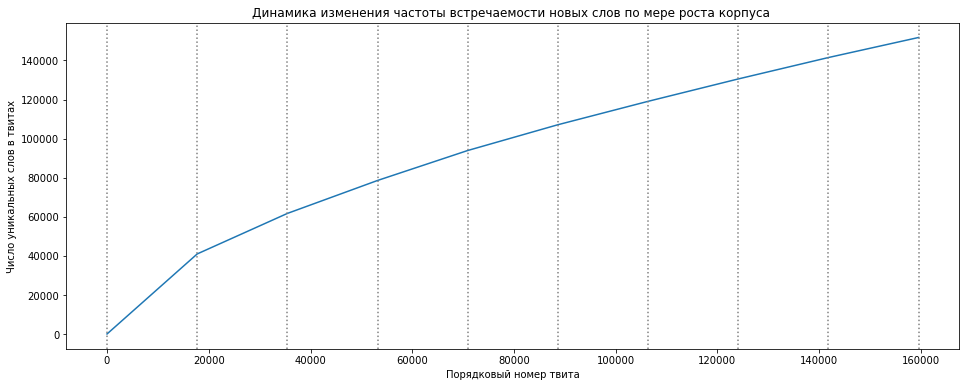

In [17]:
%%time
unique_words = []
step = 10
lim = np.linspace(0, len(data), 10)
for i in lim:
    unique_words.append(len(set(' '.join(data.dropna().loc[0:i, 'lemmatized'].values).split())))
    
plt.figure(figsize=(16, 6))
plt.plot(lim, unique_words)
plt.title('Динамика изменения частоты встречаемости новых слов по мере роста корпуса ')
plt.xlabel('Порядковый номер твита')
plt.ylabel('Число уникальных слов в твитах')

for line in list(lim):
    plt.axvline(x=line, linestyle=':', color='grey')

Действительно, в корпусе из нескольких сотен твитов почти в каждом обнаруживаются уникальные для корпуса слова, и по мере увеличения корпуса они встречаются все реже. Однако нельзя сказать, что эта динамика в какой-то момент прекращается, поэтому стоит рассматривать весь корпус целиком.

## Выделение обучающей и тестовой выборок

Разобьем датасет на обучающую и тестовую выборку, приняв объем тестовой за 25%

In [18]:
features = data['lemmatized'].to_frame()
target = data['toxic']

In [19]:
train_features, test_features, train_target, test_target = train_test_split(features, target, test_size=0.25, random_state=123)

## Удаление слов нейтральной тональности

In [20]:
stop_words = set(stopwords.words('english'))

Добавим к списку стоп-слов названия географических объектов, встречающихся в датасете, названия дней и месяцев. Начнем с извлечения из датасета всех географических объектов. Для демонстрации работы возьмем короткий участок датасета

In [21]:
%%time
places = geograpy.get_geoPlace_context(text=' '.join(data['text'].sample(100)))

Wall time: 13.2 s


Выведем по несколько стран, регионов и городов

In [22]:
display(places.countries[:3])
display(places.regions[:3])
display(places.cities[:3])

['India', 'South Africa', 'United States of America']

['Incan', 'Karate', 'News']

['Los Angeles', 'Florence', 'Arras']

~~Добавим к списку стоп-слов только названия стран, так как мноиге выявленные библиотекой `geograpy` города и регионы совпадают с простыми словами, и это ухудшает обобщающую способность модели~~ Добавим только дни недели и месяцы

In [23]:
print('Количество стоп-слов до: {}'.format(len(stop_words)))

stop_words.update([item.lower() for item in pd.date_range('2022-01-01','2023-01-01', freq='MS').month_name()],
                  [item.lower() for item in pd.date_range('2022-01-01','2023-01-01', freq='MS').day_name()]
                  
                 )
# [item.lower() for item in places.countries]
print('Количество стоп-слов после: {}'.format(len(stop_words)))

Количество стоп-слов до: 179
Количество стоп-слов после: 198


Число стоп-слов значительно увеличилось. Надеемся, на точности предсказания это тоже скажется. Загрузим заранее сформированный список стоп-слов

In [24]:
'''try:
    with open('stop_words_v3.txt', 'r') as file:
        stop_words = set(file.read().splitlines())
except:
    print('Файл не найден, сформируйте список стоп-слов заново')'''

"try:\n    with open('stop_words_v3.txt', 'r') as file:\n        stop_words = set(file.read().splitlines())\nexcept:\n    print('Файл не найден, сформируйте список стоп-слов заново')"

In [25]:
print('Итого слоп-слов: {}'.format(len(stop_words)))

Итого слоп-слов: 198


Будем считать, что большая часть - правда нейтральные слова.

# Векторизация текста и обучение моделей

## Поиск наилучших гиперпараметров при помощи GridSearchCV

Построим пайплайн, включающий в себя следующие шаги:
* Трансформер, представляющий текст в виде вектора (в качестве трансформера используется мешок слов или TF-IDF)
* Модель обучения (рассмотрим логистическую регрессию и метод опорных векторов, другие модели рассматрвиались, но слишком долго обучались и не дали хорошего результата)

Также в пайплайн можно было встроить Scaler, однако для текстов все признаки (частоты слов) имеют одинаковый масштаб и это не дало прироста точности


In [26]:
bow_ct = ColumnTransformer(transformers=[('count_vectorizer', CountVectorizer(stop_words=stop_words), 'lemmatized')])
tf_idf_ct = ColumnTransformer(transformers=[('tf_idf_vectorizer', TfidfVectorizer(stop_words=stop_words), 'lemmatized')])

lr_clf = LogisticRegression(class_weight='balanced', random_state=123, solver='sag', max_iter=10000, n_jobs=-1)
svm_clf = SVC(class_weight='balanced', random_state=123, max_iter=10000)

multi_pipe = Pipeline(steps=[('vectorizer', bow_ct), ('classifier', lr_clf)])

Переберем несколько гиперпараметров в поисках наилучшей модели

In [27]:
%%time

params = [{'vectorizer': [tf_idf_ct], 
           'vectorizer__tf_idf_vectorizer__ngram_range':[(1, 2)], 
           'classifier': [lr_clf], 
           'classifier__C': [0.5, 2, 5]
          },
          
          {'vectorizer': [tf_idf_ct], 
           'vectorizer__tf_idf_vectorizer__ngram_range':[(1,2), (1, 3), (2, 2)],
           'vectorizer__tf_idf_vectorizer__max_df':[0.8, 0.9, 1],
           'vectorizer__tf_idf_vectorizer__min_df':[2, 5, 10],
           'classifier': [svm_clf],
           'classifier__C': [0.5, 3, 6, 10],
           'classifier__gamma': [0.3, 0.9, 2]
          }
         ]

multi_gs = GridSearchCV(estimator=multi_pipe, param_grid=params, scoring='f1', cv=3, n_jobs=-1, verbose=10, error_score=0.0)
multi_gs_res = multi_gs.fit(train_features, train_target).cv_results_

Fitting 3 folds for each of 327 candidates, totalling 981 fits


C:\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
324 fits failed out of a total of 981.
The score on these train-test partitions for these parameters will be set to 0.0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
324 fits failed with the following error:
Traceback (most recent call last):
  File "C:\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\anaconda3\lib\site-packages\sklearn\pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\anaconda3\lib\site-packages\sklearn\pipeline.py", line 348, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\anaconda3\lib\site-packages\joblib\memory.py", line 352, in __ca

Wall time: 12h 10min 59s


C:\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Выведем сводную таблицу моделей с разными гиперпараметрами

In [28]:
pd.DataFrame(multi_gs_res).sort_values(by='mean_test_score', ascending=False).reset_index(drop=True).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__C,param_vectorizer,param_vectorizer__tf_idf_vectorizer__ngram_range,param_classifier__gamma,param_vectorizer__tf_idf_vectorizer__max_df,param_vectorizer__tf_idf_vectorizer__min_df,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,839.312081,3.841229,297.256259,3.598656,"SVC(C=3, class_weight='balanced', gamma=0.3, max_iter=10000, random_state=123)",3,"ColumnTransformer(transformers=[('tf_idf_vectorizer',\n TfidfVectorizer(max_df=0.8, min_df=2,\n ngram_range=(1, 2),\n stop_words={'a', 'about',\n 'above', 'after',\n 'again', 'against',\n 'ain', 'all', 'am',\n 'an', 'and', 'any',\n 'april', 'are',\n 'aren', ""aren't"",\n 'as', 'at',\n 'august', 'be',\n 'because', 'been',\n 'before', 'being',\n 'below', 'between',\n 'both', 'but',\n 'by', 'can', ...}),\n 'lemmatized')])","(1, 2)",0.3,0.9,2,"{'classifier': SVC(C=3, class_weight='balanced', gamma=0.3, max_iter=10000, random_state=123), 'classifier__C': 3, 'classifier__gamma': 0.3, 'vectorizer': ColumnTransformer(transformers=[('tf_idf_vectorizer', TfidfVectorizer(max_df=0.8, min_df=2, ngram_range=(1, 2), stop_words={'a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'april', 'are', 'aren', ""aren't"", 'as', 'at', 'august', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', ...}), 'lemmatized')]), 'vectorizer__tf_idf_vectorizer__max_df': 0.9, 'vectorizer__tf_idf_vectorizer__min_df': 2, 'vectorizer__tf_idf_vectorizer__ngram_range': (1, 2)}",0.787381,0.779184,0.774892,0.780486,0.005181,1
1,840.153359,3.484650,297.419488,2.379613,"SVC(C=3, class_weight='balanced', gamma=0.3, max_iter=10000, random_state=123)",3,"ColumnTransformer(transformers=[('tf_idf_vectorizer',\n TfidfVectorizer(max_df=0.8, min_df=2,\n ngram_range=(1, 2),\n stop_words={'a', 'about',\n 'above', 'after',\n 'again', 'against',\n 'ain', 'all', 'am',\n 'an', 'and', 'any',\n 'april', 'are',\n 'aren', ""aren't"",\n 'as', 'at',\n 'august', 'be',\n 'because', 'been',\n 'before', 'being',\n 'below', 'between',\n 'both', 'but',\n 'by', 'can', ...}),\n 'lemmatized')])","(1, 2)",0.3,0.8,2,"{'classifier': SVC(C=3, class_weight='balanced', gamma=0.3, max_iter=10000, random_state=123), 'classifier__C': 3, 'classifier__gamma': 0.3, 'vectorizer': ColumnTransformer(transformers=[('tf_idf_vectorizer', TfidfVectorizer(max_df=0.8, min_df=2, ngram_range=(1, 2), stop_words={'a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'april', 'are', 'aren', ""aren't"", 'as', 'at', 'august', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', ...}), 'lemmatized')]), 'vectorizer__tf_idf_vectorizer__max_df': 0.8, 'vectorizer__tf_idf_vectorizer__min_df': 2, 'vectorizer__tf_idf_vectorizer__ngram_range': (1, 2)}",0.787381,0.779184,0.774892,0.780486,0.005181,1
2,907.706812,2.957971,315.612825,2.884368,"SVC(C=3, class_weight='balanced', gamma=0.3, max_iter=10000, random_state=123)",3,"ColumnTransformer(transformers=[('tf_idf_vectorizer',\n TfidfVectorizer(max_df=0.8, min_df=2,\n ngram_range=(1, 2),\n stop_words={'a', 'about',\n 'above', 'after',\n 'again', 'against',\n 'ain', 'all', 'am',\n 'an', 'and', 'any',\n 'april', 'are',\n 'aren', ""aren't"",\n 'as', 'at',\n 'august', 'be',\n 'because', 'been',\n 'before', 'being',\n 'below', 'between',\n 'both', 'but',\n 'by', 'can', ...}),\n 'lemmatized')])","(1, 3)",0.3,0.8,2,"{'classifier': SVC(C=3, class_weight='balanced', gamma=0.3, max_iter=10000, random_state=123), 'classifier__C': 3, 'classifier__gamma': 0.3, 'vectorizer': ColumnTransformer(transformers=[('tf_idf_vectorizer', TfidfVectorizer(max_df=0.8, min_df=2, ngram_range=(1, 2), stop_words={'a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'april', 'are', 'aren', ""aren't"", 'as', 'at', 'august', 'be',

Сохраним лучшую модель и оценим ее точность на тестовой выборке

In [29]:
%%time
print('F1 лучшей модели по версии GridSearchCV: {:.3f}'.format(f1_score(test_target, multi_gs.predict(test_features))))

F1 лучшей модели по версии GridSearchCV: 0.776
Wall time: 2min 16s


На тестовой выборке модель показала результат не хуже, чем на кросс-валидации

## Поиск наилучших гиперпараметров при помощи Optuna

In [30]:
%%time

def objective(trial):
    
    vectorizers = trial.suggest_categorical('vectorizer', ['bow_ct', 'tf_idf_ct'])
    if vectorizers == 'bow_ct':
        vectorizer = ColumnTransformer(transformers=[('count_vectorizer', CountVectorizer(stop_words=stop_words), 'lemmatized')])
    elif vectorizers == 'tf_idf_ct':
        vectorizer =  ColumnTransformer(transformers=[('tf_idf_vectorizer', TfidfVectorizer(stop_words=stop_words), 'lemmatized')])
    
    estimators = trial.suggest_categorical('estimator', ['lr_clf', 'svm_clf'])
    if estimators == 'lr_clf':
        C = trial.suggest_float('C', 0.1, 10)
        clf = LogisticRegression(class_weight='balanced', random_state=123, solver='sag', max_iter=10000, n_jobs=-1, C=C)
    elif estimators == 'svm_clf':
        C = trial.suggest_float('C', 0.1, 10)
        gamma = trial.suggest_float('gamma', 0.1, 10)
        clf = SVC(class_weight='balanced', random_state=123, max_iter=10000, C=C, gamma=gamma)
    
    pipe = Pipeline(steps=[('vectorizer', vectorizer), ('classifier', clf)])
    
    res = cross_val_score(pipe, train_features, train_target, scoring='f1', cv=3, n_jobs=-1, error_score='raise').mean()
    
    return res
        
study = optuna.create_study(direction='maximize', sampler=RandomSampler(seed=123))
study.optimize(objective, n_trials=1, n_jobs=-1, timeout=4*60*60)

trial = study.best_trial    

[I 2022-05-02 02:30:27,312] A new study created in memory with name: no-name-fa8010e7-e70a-4be3-a46c-f3fdf5bca3aa
C:\anaconda3\lib\site-packages\optuna\study\study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(
[I 2022-05-02 02:37:58,908] Trial 0 finished with value: 0.7756004104434996 and parameters: {'vectorizer': 'tf_idf_ct', 'estimator': 'svm_clf', 'C': 4.480535885117198, 'gamma': 0.8323096794508871}. Best is trial 0 with value: 0.7756004104434996.


Wall time: 7min 31s


Выведем параметры лучшей модели и сохраним ее для расчета на тестовой выборке 

In [31]:
trial.params

{'vectorizer': 'tf_idf_ct',
 'estimator': 'svm_clf',
 'C': 4.480535885117198,
 'gamma': 0.8323096794508871}

In [32]:
def detailed_objective(trial):
   
    vectorizers = trial.suggest_categorical('vectorizer', ['bow_ct', 'tf_idf_ct'])
    if vectorizers == 'bow_ct':
        vectorizer = ColumnTransformer(transformers=[('count_vectorizer', CountVectorizer(stop_words=stop_words), 'lemmatized')])
    elif vectorizers == 'tf_idf_ct':
        vectorizer =  ColumnTransformer(transformers=[('tf_idf_vectorizer', TfidfVectorizer(stop_words=stop_words), 'lemmatized')])
    
    estimators = trial.suggest_categorical('estimator', ['lr_clf', 'svm_clf'])
    if estimators == 'lr_clf':
        C = trial.suggest_float('C', 0.1, 10)
        clf = LogisticRegression(class_weight='balanced', random_state=123, solver='sag', max_iter=10000, n_jobs=-1, C=C)
    elif estimators == 'svm_clf':
        C = trial.suggest_float('C', 0.1, 10)
        gamma = trial.suggest_float('gamma', 0.1, 10)
        clf = SVC(class_weight='balanced', random_state=123, max_iter=10000, C=C, gamma=gamma)
    
    pipe = Pipeline(steps=[('vectorizer', vectorizer), ('classifier', clf)])
    
    pipe.fit(train_features, train_target)
    res = f1_score(test_target, pipe.predict(test_features))
    
    return res

In [33]:
%%time
print('F1 лучшей модели по версии Optuna: {:.3f}'.format(detailed_objective(study.best_trial)))

C:\anaconda3\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


F1 лучшей модели по версии Optuna: 0.794
Wall time: 9min 2s


# Вывод

* Лемматизатор библиотеки Spacy лучше справляется с определением словарной формы английских слов
* Векторное преобразование по принципу TF-IDF эффективнее, чем bag of words
* Среди моделей были рассмотрены линейные модели: логистическая регрессия и метод опорных векторов с регуляризацией. Градиентный бустинг требует слишком большого времени для обучения на таком количестве признаков
* В процессе обучения было выявлено переобучение, от которого можно было бы избавиться более тщательной очисткой текста